Script to plot map of min NEP statistics

In [1]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs

from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from config import *
from utils import proj, rgb_to_hex
from functions import get_data_yr_SAFR
from make_acc_nep_SAFR import load_nep_SAFR_sub2

R[write to console]: Le chargement a nécessité le package : kde1d



In [2]:
### CST ###

reg = 'Fr'
dataset = 'SAFRAN'
ymin = 1958
ymax = 2021
years = np.arange(ymin, ymax+1, 1)
per = str(ymin) + '-' + str(ymax)
size = 60  # domain side length (number of pixels)
size_ = str(int(size*res/1000)) + 'x' + str(int(size*res/1000))
prop = 0.33  # proportion du côté de la fenêtre sans recouvrement (dans les deux directions)
step = int(round(size * prop, 0))  # décalage dans la sélection des coordonnées des sous-fenêtres
ntot = size **2  # total number of pixel within domain
th_n = 0.75  # minimum proportion of land grid cell for the sub-domain to be considered
nbweeksmin = 4
nbweeksmax = 166  # 52  # 260
ts = str(nbweeksmin) + '-' + str(nbweeksmax)
mm = np.arange(1, 12+1,1)
typ = 'kernall'  # Method to compute NEPs
sizes = {10: 5, 20: 2, 30: 1, 40: 1} #, 50: 1, 60: 1}  # domain side length (pixels) and NEP mat sub-sampling factor
prop = 0.33  # proportion du côté de la fenêtre sans recouvrement (dans les deux directions)
th_n = 0.75  # minimum proportion of land grid cell for the sub-domain to be considered
projmap = ccrs.LambertConformal(central_longitude=2.337229, central_latitude=46.8, false_easting=600000., false_northing=2200000.)

In [3]:
#~ OUTDIR

if not os.path.isdir(DATADIR + '/' + reg):
    os.mkdir(DATADIR + '/' + reg)
datadir = DATADIR + '/' + reg

if not os.path.isdir(datadir + '/' + dataset):
    os.mkdir(datadir + '/' + dataset)
datadir = datadir + '/' + dataset

if not os.path.isdir(datadir + '/' + per):
    os.mkdir(datadir + '/' + per)
datadir = datadir + '/' + per


if not os.path.isdir(FIGDIR + '/' + reg):
    os.mkdir(FIGDIR + '/' + reg)
figdir = FIGDIR + '/' + reg

if not os.path.isdir(figdir + '/' + dataset):
    os.mkdir(figdir + '/' + dataset)
figdir = figdir + '/' + dataset

if not os.path.isdir(figdir + '/' + per):
    os.mkdir(figdir + '/' + per)
figdir = figdir + '/' + per

if not os.path.isdir(figdir + '/locations_meth2'):
    os.mkdir(figdir + '/locations_meth2')
figdir = figdir + '/locations_meth2'

figdir

'/home/guillaumechagnaud/TRAVAIL/POSTDOC/IGE-Secheresse/work/output/figures/Fr/SAFRAN/1958-2021/locations_meth2'

In [4]:
#~ Get valid cells to compute matrices of precip. acc. and NEPs  -> USELESS ???
# Min and max coordinates (x, y) of the lower left pixel of sub-domains
x_min_ = x_min
x_max_ = x_max - size * res
x_min_, x_max_
y_min_ = y_min
y_max_ = y_max - size * res
(x_min_, y_min_), (x_max_, y_max_)

# Coordinates of the lower left pixel of all sub-domains
xs = pd.Series(np.arange(x_min_, x_max_+res, res))  # all x coordinates
ys = pd.Series(np.arange(y_min_, y_max_+res, res))  # all y coordinates

# Sub-sample sub-domains coordinates (-> over-lapping)
xs_ = xs[::step]
ys_ = ys[::step]

# Get all subdomains lower left (ll) coordinates (x, y)
ll_cells = []
for x in xs_:
    for y in ys_:
        ll_cells.append((x, y))
len(ll_cells)

# Get valid sub-domains: containing at least X % of land grid cells
ds = get_data_yr_SAFR(1960)
valid_cells = []

for ll_cell in ll_cells:
    x_min_ = ll_cell[0]
    x_max_ = x_min_ + size * res - res
    y_min_ = ll_cell[1]
    y_max_ = y_min_ + size * res - res
    xs = [x_min_, x_max_]
    ys = [y_min_, y_max_]

    data = ds.sel(x=slice(x_min_, x_max_), y=slice(y_min_, y_max_)).mean(dim='time').product.values

    if len(data[~np.isnan(data)]) >= ntot*th_n:
        valid_cells.append((xs, ys))

len(valid_cells)  # [(xmin, xmax), (ymin, ymax)]

9

In [5]:
ll_cells

[(60000, 1617000),
 (60000, 1777000),
 (60000, 1937000),
 (60000, 2097000),
 (220000, 1617000),
 (220000, 1777000),
 (220000, 1937000),
 (220000, 2097000),
 (380000, 1617000),
 (380000, 1777000),
 (380000, 1937000),
 (380000, 2097000),
 (540000, 1617000),
 (540000, 1777000),
 (540000, 1937000),
 (540000, 2097000),
 (700000, 1617000),
 (700000, 1777000),
 (700000, 1937000),
 (700000, 2097000)]

In [6]:
valid_cells

[([220000, 692000], [1777000, 2249000]),
 ([220000, 692000], [1937000, 2409000]),
 ([220000, 692000], [2097000, 2569000]),
 ([380000, 852000], [1777000, 2249000]),
 ([380000, 852000], [1937000, 2409000]),
 ([380000, 852000], [2097000, 2569000]),
 ([540000, 1012000], [1777000, 2249000]),
 ([540000, 1012000], [1937000, 2409000]),
 ([540000, 1012000], [2097000, 2569000])]

In [7]:
# Get minimum NEPs and location for each size
nep_min_sizes = {}
loc_min_sizes = {}
kde_sizes = {}

for size, fac in sizes.items():
    size_ = str(int(size*res/1000)) + 'x' + str(int(size*res/1000))   # sub-domain size (km x km)

    print(size_, end=' : ', flush=True)

    data = load_nep_SAFR_sub2(reg, ymin, ymax, typ, nbweeksmin, nbweeksmax, size=size)
    nep_min_sizes[size] = data[0]  # matrix dates x timescales with nep values
    loc_min_sizes[size] = data[1]  # matrix dates x timescales with indices of sub-domain with min
    #kde_sizes[size] = data[2]  # kde

80x80 : 160x160 : 240x240 : 320x320 : 

In [8]:
# Get France polygon and reprojection SAFRAN CRS
cnydbffile = SHAPEDIR + '/world-boundaries/world-administrative-boundaries.dbf'
dfcny = gpd.read_file(cnydbffile)
dffra = gpd.GeoSeries(dfcny.iloc[93]['geometry'])
dffra.set_crs(dfcny.crs, inplace=True)
dffra_reproj = dffra.to_crs(proj)

In [9]:
# Plot setup
xlims = (50000., 1200000.)
ylims = (1600000., 2750000.)
xtcks = np.linspace(xlims[0], xlims[1], 6)
ytcks = np.linspace(ylims[0], ylims[1], 6)
xtlbs = [int(xt/1000) for xt in xtcks]
ytlbs = [int(yt/1000) for yt in ytcks]


>> 1961 <<
10 : 20 : 30 : 40 : 

SystemExit: 

/home/guillaumechagnaud/anaconda3/envs/cmip6/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


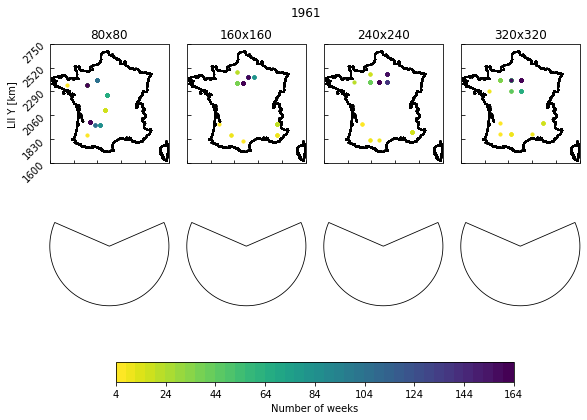

In [12]:
#~ Plot location of min window of all time scales, for each size and year

if not os.path.isdir(figdir + '/timescales'):
    os.mkdir(figdir + '/timescales')
figdir_ts = figdir + '/timescales'

cmap = 'viridis_r'
cmap = plt.cm.get_cmap(cmap)

ncols = np.arange(nbweeksmin, nbweeksmax+1, 4)
norm = BoundaryNorm(ncols, ncolors=cmap.N, clip=True)


for y in years[int(nbweeksmax/52):]:  # remove years with NANs
    print("\n>> {0} <<".format(y))

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(9.5, 6.5), subplot_kw={'projection': projmap})

    plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.15, hspace=0.2)

    i=0
    j=0

    for size, fac in sizes.items():
        print(size, end=' : ', flush=True)

        size_ = str(int(size * res /1000)) + 'x' + str(int(size * res /1000))
        #print(i, j, end=' : ', flush=True)
        if j==ax.shape[1]:
            j=0
            i=i+1
        
        ax_ = ax[i][j]

        # Get dates of min NEP for year y
        datesmin = nep_min_sizes[size][nep_min_sizes[size].index.year == y].idxmin(axis=0).values

        # Get index of dates of min NEP of year y (in the NEP matrix)
        idxsmin = nep_min_sizes[size].index.get_indexer_for((datesmin))
        idxsmin = idxsmin[idxsmin >= 0]
        
        datadir_size = datadir + '/' + size_
        coords_min_size_fac = os.listdir(datadir_size)[:-1][::fac]  # -> coordonnées des fenêtres considérées

        for k, idx in enumerate(idxsmin):  # idx: index of dates, k: index of timescale
            locmin = loc_min_sizes[size][idx, k]  # -> index of grid cell with min ACC (used to fit kernel in meth2)
            #print(delx, dely)

            mincellcoords = coords_min_size_fac[locmin]
            idxsep = mincellcoords.find('-')
            xc = int(mincellcoords[:idxsep]) + (size * res) / 2
            yc = int(mincellcoords[idxsep+1:]) + (size * res) / 2

            p = ax_.scatter(xc, yc, c=k+nbweeksmin, s=10, linewidths=1., norm=norm, cmap=cmap)

            dffra_reproj.boundary.plot(ax=ax_, color='k')

        ax_.set_xticks(xtcks)
        ax_.set_yticks(ytcks)
        ax_.tick_params(axis='x', direction='in')
        ax_.tick_params(axis='y', direction='in')
        
        if j == 0:
            ax_.set_yticklabels(ytlbs, rotation=45)
            ax_.set_ylabel('LII Y [km]')
        else:
            ax_.set_yticklabels([])
        if i == ax.shape[0]-1:
            ax_.set_xticklabels(xtlbs, rotation=45)
            ax_.set_xlabel('LII X [km]')
        else:
            ax_.set_xticklabels([])

        ax_.set_xlim(xlims)
        ax_.set_ylim(ylims)
        
        ax_.set_title('{0}'.format(size_))  #({1}) , len(idxsmin)))
        j=j+1
        
        #sys.exit()

    fig.colorbar(p, ax=ax[:len(list(sizes.keys()))], orientation='horizontal', label='Number of weeks', shrink=0.75, pad=0.15)
    fig.suptitle(y)
    
    # Save

    figfile = figdir_ts + '/' + str(y) + '.pdf'
    fig.savefig(figfile)

    sys.exit()

figfile


>> 1961 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1962 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1963 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1964 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1965 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1966 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1967 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1968 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1969 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1970 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1971 <<
4 : 8 : 16 : 32 : 52 : 

KeyboardInterrupt: 

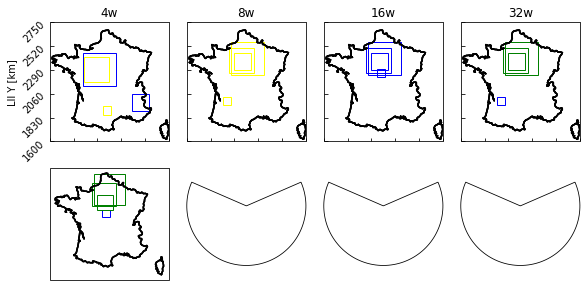

In [13]:
#~ Plot location of min window of each size, for some timescales and all years + indicate season

if not os.path.isdir(figdir + '/sizes_seasons'):
    os.mkdir(figdir + '/sizes_seasons')
figdir_sizes = figdir + '/sizes_seasons'

cmap = 'viridis_r'
cmap = plt.cm.get_cmap(cmap)

ncols = [1, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.]
norm = BoundaryNorm(ncols, ncolors=cmap.N, clip=True)


# Markers = rectangles
mrk10 = Line2D([0], [0], marker='s', color='w', markerfacecolor='w', 
               markeredgecolor='k', markeredgewidth=1., markersize=5)
mrk20 = Line2D([0], [0], marker='s', color='w', markerfacecolor='w', 
               markeredgecolor='k', markeredgewidth=1., markersize=8.5)
mrk30 = Line2D([0], [0], marker='s', color='w', markerfacecolor='w',
               markeredgecolor='k', markeredgewidth=1., markersize=12)
mrk40 = Line2D([0], [0], marker='s', color='w', markerfacecolor='w',
               markeredgecolor='k', markeredgewidth=1., markersize=15.5)

mrkDJF = Line2D([0], [0], marker='s', color='w', markerfacecolor='w', 
               markeredgecolor='b', markeredgewidth=1., markersize=12)
mrkMAM = Line2D([0], [0], marker='s', color='w', markerfacecolor='w', 
               markeredgecolor='g', markeredgewidth=1., markersize=12)
mrkJJA = Line2D([0], [0], marker='s', color='w', markerfacecolor='w',
               markeredgecolor='r', markeredgewidth=1., markersize=12)
mrkSON = Line2D([0], [0], marker='s', color='w', markerfacecolor='w',
               markeredgecolor='yellow', markeredgewidth=1., markersize=12)


cols = {1: 'b', 2: 'b', 3: 'g', 4: 'g', 5: 'g', 6: 'r',
        7: 'r', 8: 'r', 9: 'yellow', 10: 'yellow', 11: 'yellow', 12: 'b'}
ts = [4, 8, 16, 32, 52, 84, 102, 163]

for y in years[int(nbweeksmax/52):]:  # remove years with NANs
    print("\n>> {0} <<".format(y))

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(9.5, 7.), subplot_kw={'projection': projmap})

    plt.subplots_adjust(bottom=0.35, top=0.9, wspace=0.15, hspace=0.05)

    i=0
    j=0

    for t in ts:
        print(t, end=' : ', flush=True)
        idxts = np.where(data[0].columns == t)[0][0]
        if j==ax.shape[1]:
            i=i+1
            j=0
            
        ax_ts = ax[i]

        for size, fac in sizes.items():        
            #print(size)
            size_ = str(int(size * res /1000)) + 'x' + str(int(size * res /1000))
            ax_ts_ = ax_ts[j]

            nep = nep_min_sizes[size][t][nep_min_sizes[size][t].index.year == y].min(axis=0)
            # Get dates of min NEP for year y
            datemin = nep_min_sizes[size][t][nep_min_sizes[size][t].index.year == y].idxmin(axis=0)
            m = datemin.month

            # Get index of dates of min NEP of year y (in the NEP matrix)
            idxmin = nep_min_sizes[size].index.get_indexer_for(([datemin]))

            datadir_size = datadir + '/' + size_
            coords_min_size_fac = os.listdir(datadir_size)[:-1][::fac]  # -> coordonnées des fenêtres considérées

            locmin = loc_min_sizes[size][idxmin, idxts] [0] # -> index of grid cell with min ACC (used to fit kernel in meth2)

            mincellcoords = coords_min_size_fac[locmin]
            idxsep = mincellcoords.find('-')
            xll = int(mincellcoords[:idxsep])
            yll = int(mincellcoords[idxsep+1:])

            rec = Rectangle((xll, yll), size*res, size*res, color=cols[m], fill=False, lw=1.)
            ax_ts_.add_patch(rec)

            dffra_reproj.boundary.plot(ax=ax_ts_, color='k')

        ax_ts_.set_xticks(xtcks)
        ax_ts_.set_yticks(ytcks)
        ax_ts_.tick_params(axis='x', direction='in')
        ax_ts_.tick_params(axis='y', direction='in')
        
        if j == 0:
            ax_ts_.set_yticklabels(ytlbs, rotation=45)
            ax_ts_.set_ylabel('LII Y [km]')
        else:
            ax_ts_.set_yticklabels([])
        if i == ax.shape[0]-1:
            ax_ts_.set_xticklabels(xtlbs, rotation=45)
            ax_ts_.set_xlabel('LII X [km]')
        else:
            ax_ts_.set_xticklabels([])

        ax_ts_.set_xlim(xlims)
        ax_ts_.set_ylim(ylims)
        
        ax_ts_.set_title('{0}w'.format(t))  #({1}) , len(idxsmin)))

        j=j+1

    fig.suptitle(y)

    handles = [mrk10, mrk20, mrk30, mrk40, mrkDJF, mrkMAM, mrkJJA, mrkSON]
    labels = [str(int(size * res /1000)) + 'x' + str(int(size * res /1000)) for size in sizes.keys()] + ['DJF', 'MAM', 'JJA', 'SON']
    fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.25, 0.1, 0.5, 0.5), ncol=4, 
               mode="expand", borderaxespad=0., title='Space scales [km] and seasons')

    # Save

    figfile = figdir_sizes + '/' + str(y) + '.pdf'
    fig.savefig(figfile)
    
    plt.close()

figfile

In [26]:
#~ Plot location of min window of each size, for some timescales and all years + indicate NEP

if not os.path.isdir(figdir + '/sizes_nep'):
    os.mkdir(figdir + '/sizes_nep')
figdir_sizes = figdir + '/sizes_nep'

cmap = 'viridis_r'
cmap = plt.cm.get_cmap(cmap)

ncols = [0., 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.]
norm = BoundaryNorm(ncols, ncolors=cmap.N, clip=True)


# Markers = shapes
mrk10 = Line2D([0], [0], marker='o', color='w', markerfacecolor='w', 
               markeredgecolor='k', markeredgewidth=1., markersize=5)
mrk20 = Line2D([0], [0], marker='s', color='w', markerfacecolor='w', 
               markeredgecolor='k', markeredgewidth=1., markersize=5)
mrk30 = Line2D([0], [0], marker='^', color='w', markerfacecolor='w',
               markeredgecolor='k', markeredgewidth=1., markersize=5)
mrk40 = Line2D([0], [0], marker='d', color='w', markerfacecolor='w',
               markeredgecolor='k', markeredgewidth=1., markersize=5)

size_mrks = {10: 'o', 20: 's', 30: '^', 40: 'd'}

ts = [4, 8, 16, 32, 52, 84, 102, 163]

for y in years[int(nbweeksmax/52):]:  # remove years with NANs
    print("\n>> {0} <<".format(y))

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(9.5, 6.5), subplot_kw={'projection': projmap})

    plt.subplots_adjust(bottom=0.15, top=0.9, wspace=0.15, hspace=0.25)

    i=0
    j=0

    for t in ts:
        print(t, end=' : ', flush=True)
        idxts = np.where(data[0].columns == t)[0][0]
        if j==ax.shape[1]:
            i=i+1
            j=0
            
        ax_ts = ax[i]

        for size, fac in sizes.items():        
            #print(size)
            size_ = str(int(size * res /1000)) + 'x' + str(int(size * res /1000))
            ax_ts_ = ax_ts[j]

            nep = nep_min_sizes[size][t][nep_min_sizes[size][t].index.year == y].min(axis=0)
            # Get dates of min NEP for year y
            datemin = nep_min_sizes[size][t][nep_min_sizes[size][t].index.year == y].idxmin(axis=0)

            # Get index of dates of min NEP of year y (in the NEP matrix)
            idxmin = nep_min_sizes[size].index.get_indexer_for(([datemin]))

            datadir_size = datadir + '/' + size_
            coords_min_size_fac = os.listdir(datadir_size)[:-1][::fac]  # -> coordonnées des fenêtres considérées
            
            locmin = loc_min_sizes[size][idxmin, idxts] [0] # -> index of grid cell with min ACC (used to fit kernel in meth2)

            mincellcoords = coords_min_size_fac[locmin]
            idxsep = mincellcoords.find('-')
            xc = int(mincellcoords[:idxsep]) + (size * res) / 2   # center of the grid cell (x)
            yc = int(mincellcoords[idxsep+1:]) + (size * res) / 2 # center of the grid cell (y)

            p = ax_ts_.scatter(xc, yc, marker=size_mrks[size], c=nep, norm=norm, cmap=cmap, edgecolors='k', linewidths=0.25, s=15) #, label=size_)

            dffra_reproj.boundary.plot(ax=ax_ts_, color='k')

        ax_ts_.set_xticks(xtcks)
        ax_ts_.set_yticks(ytcks)
        ax_ts_.tick_params(axis='x', direction='in')
        ax_ts_.tick_params(axis='y', direction='in')
        
        if j == 0:
            ax_ts_.set_yticklabels(ytlbs, rotation=45)
            ax_ts_.set_ylabel('LII Y [km]')
        else:
            ax_ts_.set_yticklabels([])
        if i == ax.shape[0]-1:
            ax_ts_.set_xticklabels(xtlbs, rotation=45)
            ax_ts_.set_xlabel('LII X [km]')
        else:
            ax_ts_.set_xticklabels([])

        ax_ts_.set_xlim(xlims)
        ax_ts_.set_ylim(ylims)
        
        ax_ts_.set_title('{0}w'.format(t))  #({1}) , len(idxsmin)))

        j=j+1

    fig.colorbar(p, ax=ax[:4], orientation='horizontal', label='NEP', shrink=0.5, pad=0.175)

    fig.suptitle(y)

    handles = [mrk10, mrk20, mrk30, mrk40]
    labels = [str(int(size * res /1000)) + 'x' + str(int(size * res /1000)) for size in sizes.keys()]
    fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.25, 0.075, 0.5, 0.5), ncol=4, 
               mode="expand", borderaxespad=0., title='Space scales [km]')

    # Save

    figfile = figdir_sizes + '/' + str(y) + '.pdf'
    fig.savefig(figfile)
    
    plt.close()

figfile


>> 1961 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1962 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1963 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1964 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1965 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1966 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1967 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1968 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1969 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1970 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1971 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1972 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1973 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1974 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1975 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1976 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1977 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1978 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1979 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1980 <<


'/home/guillaumechagnaud/TRAVAIL/POSTDOC/IGE-Secheresse/work/output/figures/Fr/SAFRAN/1958-2021/locations_meth2/sizes_nep/2021.pdf'

In [38]:
#~ Plot location of min window of each size, for some timescales and all years

if not os.path.isdir(figdir + '/years'):
    os.mkdir(figdir + '/years')
figdir_years = figdir + '/years'

size_mrks = {10: 'o', 20: 's', 30: '^', 40: 'd'}
ts = [4, 8, 16, 32, 52, 84, 102, 163]


# Get data

xy_years = []

for y in years[int(nbweeksmax/52):]:  # remove years with NANs
    print("\n>> {0} <<".format(y))
    
    xy_ts = []

    for t in ts:
        print(t, end=' : ', flush=True)
        idxts = np.where(data[0].columns == t)[0][0]
        
        xy_sizes = []

        for size, fac in sizes.items():        
            #print(size)
            size_ = str(int(size * res /1000)) + 'x' + str(int(size * res /1000))

            # Get dates of min NEP for year y
            datemin = nep_min_sizes[size][t][nep_min_sizes[size][t].index.year == y].idxmin(axis=0)

            # Get index of dates of min NEP of year y (in the NEP matrix)
            idxmin = nep_min_sizes[size].index.get_indexer_for(([datemin]))

            datadir_size = datadir + '/' + size_
            coords_min_size_fac = os.listdir(datadir_size)[:-1][::fac]  # -> coordonnées des fenêtres considérées
            
            #for k, idx in enumerate(idxsmin):  # idx: index of dates, k: index of timescale
            locmin = loc_min_sizes[size][idxmin, idxts] [0] # -> index of grid cell with min ACC (used to fit kernel in meth2)
            #print(delx, dely)

            mincellcoords = coords_min_size_fac[locmin]
            idxsep = mincellcoords.find('-')
            xc = int(mincellcoords[:idxsep]) + (size * res) / 2
            yc = int(mincellcoords[idxsep+1:]) + (size * res) / 2

            xy_sizes.append((xc, yc))

        xy_ts.append(xy_sizes)

    xy_years.append(xy_ts)

xy_years = np.asarray(xy_years)
xys = xy_years.swapaxes(0, 2)


>> 1961 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1962 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1963 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1964 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1965 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1966 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1967 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1968 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1969 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1970 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1971 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1972 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1973 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1974 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1975 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1976 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1977 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1978 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1979 <<
4 : 8 : 16 : 32 : 52 : 84 : 102 : 163 : 
>> 1980 <<



>>> 80x80 <<<

4w
1961 : 1962 : 1963 : 1964 : 1965 : 1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 2012 : 2013 : 2014 : 2015 : 2016 : 2017 : 2018 : 2019 : 2020 : 2021 : 
8w
1961 : 1962 : 1963 : 1964 : 1965 : 1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 : 1978 : 1979 : 1980 : 1981 : 1982 : 1983 : 1984 : 1985 : 1986 : 1987 : 1988 : 1989 : 1990 : 1991 : 1992 : 1993 : 1994 : 1995 : 1996 : 1997 : 1998 : 1999 : 2000 : 2001 : 2002 : 2003 : 2004 : 2005 : 2006 : 2007 : 2008 : 2009 : 2010 : 2011 : 2012 : 2013 : 2014 : 2015 : 2016 : 2017 : 2018 : 2019 : 2020 : 2021 : 
16w
1961 : 1962 : 1963 : 1964 : 1965 : 1966 : 1967 : 1968 : 1969 : 1970 : 1971 : 1972 : 1973 : 1974 : 1975 : 1976 : 1977 :

'/home/guillaumechagnaud/TRAVAIL/POSTDOC/IGE-Secheresse/work/output/figures/Fr/SAFRAN/1958-2021/locations_meth2/years/320x320.pdf'

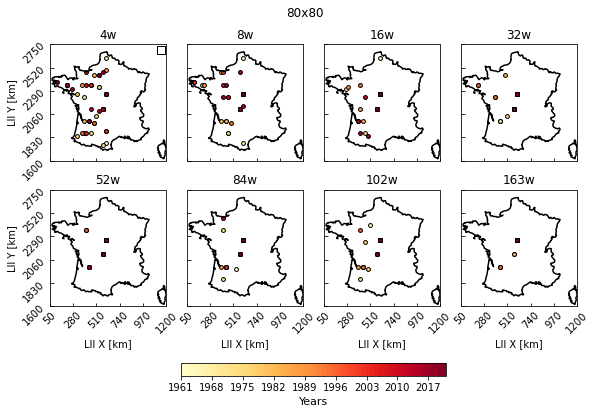

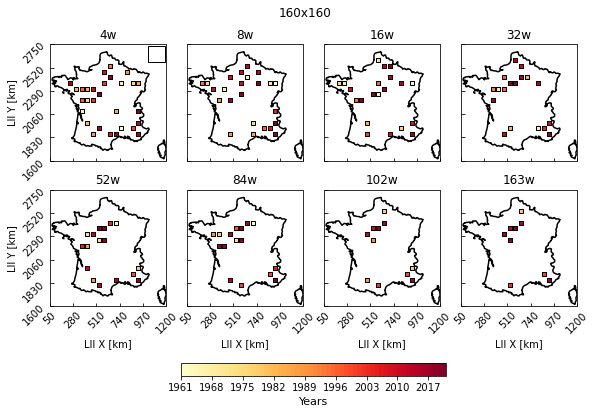

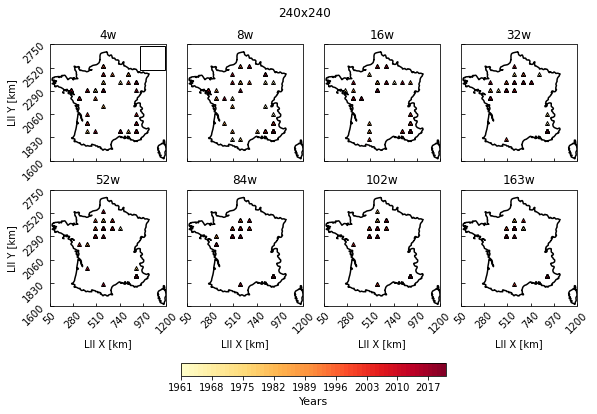

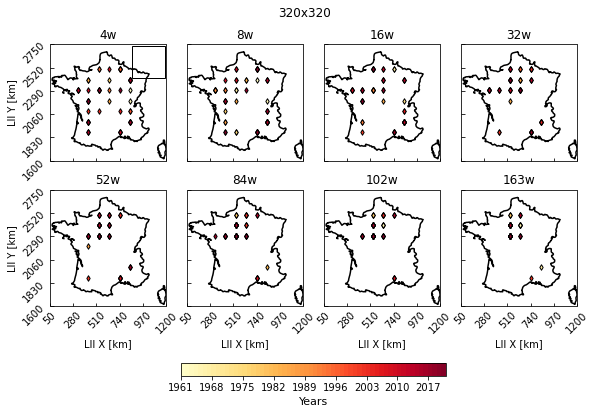

In [40]:
# Plot

cmap = plt.cm.get_cmap("YlOrRd")
ncols = np.arange(1, len(years[int(nbweeksmax/52):])+1, 1)
inds = np.round(np.linspace(0, 256, len(ncols)))
inds = np.array(inds, dtype=int)
cols = cmap(inds)
cols = mpl.colors.ListedColormap(colors=cols)
cols = [rgb_to_hex(i * (256 - 1)) for i in cols.colors]

sm = plt.cm.ScalarMappable(cmap=cmap)  # for colorbar
sm.set_array([])


for isize, (size, mrk) in enumerate(size_mrks.items()):
    size_ = str(int(size * res /1000)) + 'x' + str(int(size * res /1000))
    print('\n>>> {0} <<<'.format(size_))
    
    rec = Rectangle((xlims[1]-(size*res)-2*res, ylims[1]-(size*res)-2*res), size*res, size*res, color='k', fill=False, lw=1.)

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(9.5, 6.5), subplot_kw={'projection': projmap})

    plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.15, hspace=0.25)

    i=0
    j=0

    for it, t in enumerate(ts):
        print('\n{0}w'.format(t))
        if j==ax.shape[1]:
            i=i+1
            j=0

        ax_ = ax[i][j]
        
        for iy, y in enumerate(years[int(nbweeksmax/52):]):
            print(y, end=' : ', flush=True)
            xc, yc = xys[isize][it][iy]

            p = ax_.scatter(xc, yc, marker=mrk, c=cols[iy], edgecolors='k', linewidths=1., s=15, label=y)


        dffra_reproj.boundary.plot(ax=ax_, color='k')

        ax_.set_xticks(xtcks)
        ax_.set_yticks(ytcks)
        ax_.tick_params(axis='x', direction='in')
        ax_.tick_params(axis='y', direction='in')

        if j == 0:
            ax_.set_yticklabels(ytlbs, rotation=45)
            ax_.set_ylabel('LII Y [km]')
        else:
            ax_.set_yticklabels([])

        if i == ax.shape[0]-1:
            ax_.set_xticklabels(xtlbs, rotation=45)
            ax_.set_xlabel('LII X [km]')
        else:
            ax_.set_xticklabels([])

        ax_.set_xlim(xlims)
        ax_.set_ylim(ylims)
        
        ax_.set_title('{0}w'.format(t))  #({1}) , len(idxsmin)))

        j=j+1

    ax[0][0].add_patch(rec)

    fig.suptitle(size_)

    cb = plt.colorbar(sm, orientation='horizontal', boundaries=years[int(nbweeksmax/52):], ax=ax, pad=0.15, shrink=0.5)
    cb.set_label('Years', fontsize=11)
    #cb.ax.set_xticklabels([])


    # Save

    figfile = figdir_years + '/' + size_ + '.pdf'
    fig.savefig(figfile)
    
figfile

In [ ]:
#~ Make density map of min NEP locations

# fill, for each size, a latxlon matrix with, for each year, 1 at the location of the min and 0 elsewhere
# -> years x (latxlon) matrix
# relative sum across years: sum / tot(=Nyears)
# plot in the 2D (latxlon) space

# for y in years[]:
# find locmin
# for icell, cell in enumerate(valid_cells):
# if icell == locmin:
# out.append(1) 
# else:
# out.append(0)
